# 0.0. IMPORTS

In [1]:
import os
import pickle
import inflection 
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.ticker   as mticker
import matplotlib.colors   as mcolors
import matplotlib.pyplot   as plt
import time

from scipy                   import stats
from operator                import attrgetter
import datetime
from IPython.core.display    import HTML
from IPython.display         import Image
from imblearn                import combine as c
from sklearn.preprocessing   import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble        import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, cross_val_score,StratifiedKFold
from sklearn.linear_model    import LogisticRegression
from xgboost                 import XGBClassifier, DMatrix
import math

import lightgbm as lgbm
 
# model's metrics
from sklearn.metrics        import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,\
confusion_matrix, matthews_corrcoef, make_scorer, roc_curve, precision_recall_curve

import scikitplot as skplt

import warnings
warnings.filterwarnings('ignore')

## 0.1. Helper Functions

In [2]:
    display( HTML( '<style>.container { width:100% !important; }</style>') )

## 0.2. Loading Data

In [3]:
# reading files
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory=True)
df_store_raw = pd.read_csv( 'data/store.csv', low_memory=True)

# merging files
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on= 'Store')

# 1.0. STEP 1 - DATA DESCRIPTION

In [4]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old) )

# rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [6]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Columns: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [9]:
df1['competition_distance'].max()

75860.0

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [11]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

# competition_open_since_month
df1['competition_open_since_month'] =  df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=True)
                                
# competition_open_since_year        
df1['competition_open_since_year'] =  df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=True)
                                                                                          
# promo2_since_week
df1['promo2_since_week'] =  df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=True)

# promo2_since_year  
df1['promo2_since_year'] =  df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=True)

In [12]:
# promo_interval 
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',9: 'Sep' ,10: 'Oct', 11: 'Nov',  12: 'Dec'}


df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply (lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1)

In [15]:
df1.sample(5).T

,700432,69722,294300,36499,52232
store,998,593,1057,820,943
day_of_week,6,6,5,1,1
date,2013-10-12 00:00:00,2015-05-30 00:00:00,2014-10-31 00:00:00,2015-06-29 00:00:00,2015-06-15 00:00:00
sales,3465,9051,6792,17766,10185
customers,470,1087,699,1287,785
open,1,1,1,1,1
promo,0,0,0,1,1
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,a,a,d,a,d


## 1.6. Change Types

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [18]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int', errors='ignore' )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int', errors='ignore' )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int', errors='ignore' )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int', errors='ignore' )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical

In [20]:
num_att = df1.select_dtypes( include= ['int64', 'float64'] )
cat_att = df1.select_dtypes( exclude= ['int64', 'float64', 'datetime64[ns]'] )

## 1.7.1. Numerical Attributes

In [21]:
cat_att.sample()

,state_holiday,store_type,assortment,competition_open_since_month,competition_open_since_year,promo2_since_week,promo2_since_year,promo_interval,month_map
897192,0,a,a,7,2015,16,2013,0,Apr


In [22]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_att.apply( np.mean)  ).T
ct2 = pd.DataFrame( num_att.apply( np.median) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_att.apply ( np.std )).T
d2 = pd.DataFrame( num_att.apply ( min )).T
d3 = pd.DataFrame( num_att.apply ( max )).T
d4 = pd.DataFrame( num_att.apply ( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_att.apply ( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_att.apply ( lambda x: x.kurtosis() ) ).T
 
    
# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.165966,0.0,0.372050,1.795644,1.224338


<AxesSubplot:xlabel='sales', ylabel='Density'>

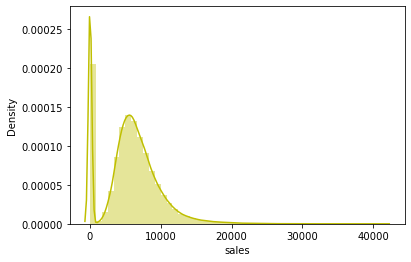

In [23]:
sns.distplot(df1['sales'],color='y')

## 1.7.2. Categorical Attributes

In [24]:
cat_att.apply( lambda x: x.unique().shape[0] )

state_holiday                    5
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     23
promo2_since_week               52
promo2_since_year                7
promo_interval                   4
month_map                       12
dtype: int64

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

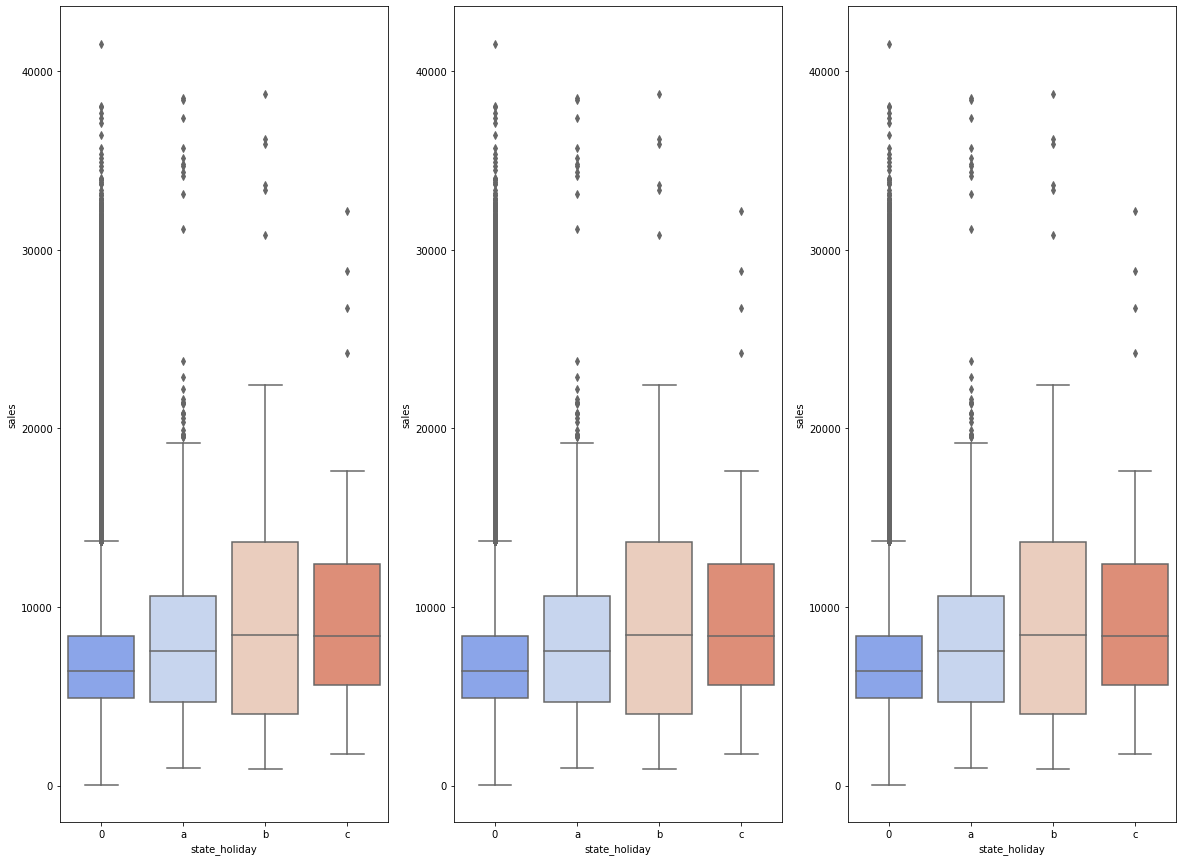

In [25]:
fig, aux1 = plt.subplots(figsize=(20,15))
aux1 = df1[(df1['state_holiday'] != 0) & (df1['sales'] > 0)]
plt.subplot(1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux1, palette='coolwarm')

plt.subplot(1, 3, 2)
sns.boxplot( x='state_holiday', y='sales', data=aux1, palette='coolwarm' )

plt.subplot(1, 3, 3)
sns.boxplot( x='state_holiday', y='sales', data=aux1, palette='coolwarm' )

# 2.0. STEP 2 - FEATURE ENGINEERING

In [26]:
df2 = df1.copy()

## 2.1. Hypothesis Mindmap

## 2.2. Creating Hypothesis

In [27]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear
# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# transform 'float' to 'int' because of error
# df2['competition_open_since_year'] = df2['competition_open_since_year'].astype(int)
# df2['competition_open_since_month'] = df2['competition_open_since_month'].astype(int)

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'],  month=x['competition_open_since_month'], day= 1), axis=1) 
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) /30 ).apply( lambda x: x.days ).astype( int )
# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply ( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'] ) /7 ).apply( lambda x: x.days ).astype ( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a'else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

## 2.3. Final Hypothesis

In [28]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                     int64
month        

In [29]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. PASSO 3 - FILTRAGEM DE VARIÁVEIS

In [30]:
df3 = df2.copy()

## 3.1. Filtragem das linhas

In [31]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Seleção das colunas

In [32]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )


In [33]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0.xx

# 5.0.

# 6.0.

# 7.0.

# 8.0.

# 1.0.